In [1]:
#Kernal: Python[conda env:rapids]

#Library imports
import time
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
import pickle
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from natsort import natsorted

import cupy as cp
import cupyx as cpx
import cupyx
import cugraph

import cudf
import math

import h5py
import scipy

import dask
import dask_cudf
import rmm

from dask_cuda import initialize, LocalCUDACluster
from dask import delayed, dataframe
from dask.dataframe.utils import make_meta
from dask.distributed import Client, default_client
from dask_cuda.local_cuda_cluster import cuda_visible_devices
import dask.dataframe as dd

from cuml.manifold import TSNE, UMAP
from cuml.linear_model import LinearRegression

from sklearn.decomposition import PCA
from cuml.dask.cluster import KMeans as cu_dask_KMeans
from cuml.dask.manifold import UMAP as cu_dask_UMAP
from cuml.dask.linear_model import LinearRegression as cu_dask_LinearRegression
from cuml.dask.neighbors import NearestNeighbors as cu_dask_NearestNeighbors

#Better Rapids Leiden import
import better_rapids_leiden as brl

#These need to present as .py files in the directory.
import rapids_scanpy_funcs as rsc
import utils as utils

#RAPIDS manual recommended imports
import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

#This lets you oversubscribe memory on the GPU.
rmm.reinitialize(managed_memory=False)
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

### ENTIRE DATASET

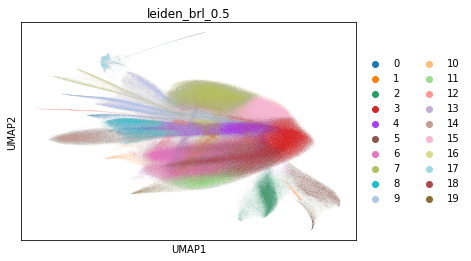

In [2]:
#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering - Resolution at 0.5 was picked for analysis.
brl.leiden(adata, key_added="leiden_brl_0.25", resolution=0.25)
brl.leiden(adata, key_added="leiden_brl_0.5", resolution=0.5)
brl.leiden(adata, key_added="leiden_brl_0.75", resolution=0.75)
brl.leiden(adata, key_added="leiden_brl_1.0", resolution=1.0)

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='leiden_brl_0.5')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_filtered_split_adj_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_filtered_split_adj_2024_08_15.csv")

#Migrate to commandline R for sceasy.

### AIRWAY

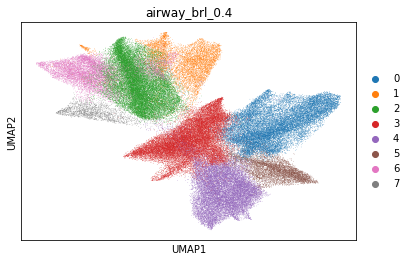

In [4]:
## SUBLINEAGE OBJECT CLUSTERING - ENTIRE AIRWAY OBJECT

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_airway', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering - Resolution at 0.4 was picked for this analysis.
brl.leiden(adata, key_added="airway_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="airway_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="airway_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="airway_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="airway_brl_0.5", resolution=0.5)

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='airway_brl_0.4')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_airway_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_airway_2024_08_15.csv")

#Migrate to commandline R for sceasy.

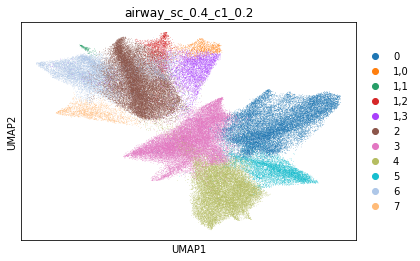

In [5]:
## SUBLINEAGE OBJECT CLUSTERING - AIRWAY (SUBCLUSTERING)

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_airway', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering - Resolution at 0.4 was picked for this analysis.
brl.leiden(adata, key_added="airway_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="airway_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="airway_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="airway_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="airway_brl_0.5", resolution=0.5)

#Change data type for leiden column to string and to category
adata.obs['airway_brl_0.4'] = adata.obs['airway_brl_0.4'].astype('str')
adata.obs['airway_brl_0.4'] = adata.obs['airway_brl_0.4'].astype('category')

#Subclustering for clusters 1 and 4
brl.leiden(adata, key_added="airway_sc_0.4_c1_0.1", resolution=0.1, restrict_to = ("airway_brl_0.4", ["1"]))
brl.leiden(adata, key_added="airway_sc_0.4_c1_0.2", resolution=0.2, restrict_to = ("airway_brl_0.4", ["1"]))
brl.leiden(adata, key_added="airway_sc_0.4_c1_0.3", resolution=0.3, restrict_to = ("airway_brl_0.4", ["1"]))
brl.leiden(adata, key_added="airway_sc_0.4_c1_0.4", resolution=0.4, restrict_to = ("airway_brl_0.4", ["1"]))
brl.leiden(adata, key_added="airway_sc_0.4_c1_0.5", resolution=0.5, restrict_to = ("airway_brl_0.4", ["1"]))

brl.leiden(adata, key_added="airway_sc_0.4_c4_0.1", resolution=0.1, restrict_to = ("airway_brl_0.4", ["4"]))
brl.leiden(adata, key_added="airway_sc_0.4_c4_0.2", resolution=0.2, restrict_to = ("airway_brl_0.4", ["4"]))
brl.leiden(adata, key_added="airway_sc_0.4_c4_0.3", resolution=0.3, restrict_to = ("airway_brl_0.4", ["4"]))
brl.leiden(adata, key_added="airway_sc_0.4_c4_0.4", resolution=0.4, restrict_to = ("airway_brl_0.4", ["4"]))
brl.leiden(adata, key_added="airway_sc_0.4_c4_0.5", resolution=0.5, restrict_to = ("airway_brl_0.4", ["4"]))

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='airway_sc_0.4_c1_0.2')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_airway_subclustering_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_airway_subclustering_2024_08_15.csv")

#Migrate to commandline R for sceasy.

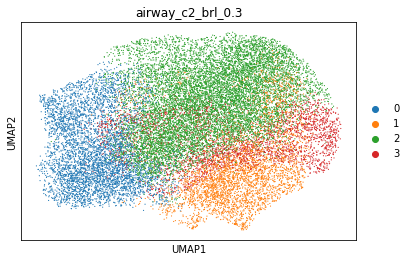

In [2]:
## SUBLINEAGE OBJECT CLUSTERING - AIRWAY (RECLUSTERING OF CLUSTER 2)

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_airway_c2', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering - Resolution at 0.4 was picked for this analysis.
brl.leiden(adata, key_added="airway_c2_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="airway_c2_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="airway_c2_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="airway_c2_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="airway_c2_brl_0.5", resolution=0.5)

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='airway_c2_brl_0.3')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_airway_reclustering_c2_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_airway_reclustering_c2_2024_08_15.csv")

#Migrate to commandline R for sceasy.

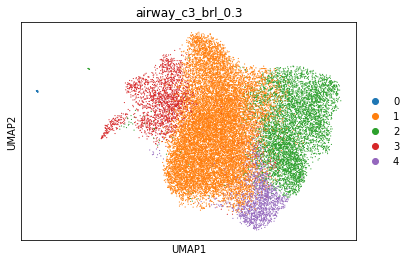

In [3]:
## SUBLINEAGE OBJECT CLUSTERING - AIRWAY (RECLUSTERING OF CLUSTER 3)

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_airway_c3', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering - Resolution at 0.4 was picked for this analysis.
brl.leiden(adata, key_added="airway_c3_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="airway_c3_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="airway_c3_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="airway_c3_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="airway_c3_brl_0.5", resolution=0.5)

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='airway_c3_brl_0.3')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_airway_reclustering_c3_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_airway_reclustering_c3_2024_08_15.csv")

#Migrate to commandline R for sceasy.

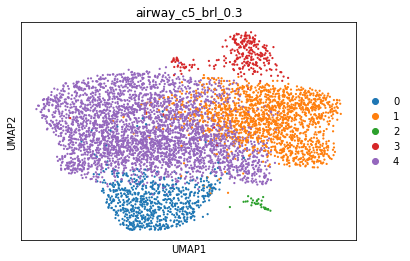

In [4]:
## SUBLINEAGE OBJECT CLUSTERING - AIRWAY (RECLUSTERING OF CLUSTER 5)

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_airway_c5', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering - Resolution at 0.4 was picked for this analysis.
brl.leiden(adata, key_added="airway_c5_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="airway_c5_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="airway_c5_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="airway_c5_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="airway_c5_brl_0.5", resolution=0.5)

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='airway_c5_brl_0.3')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_airway_reclustering_c5_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_airway_reclustering_c5_2024_08_15.csv")

#Migrate to commandline R for sceasy.

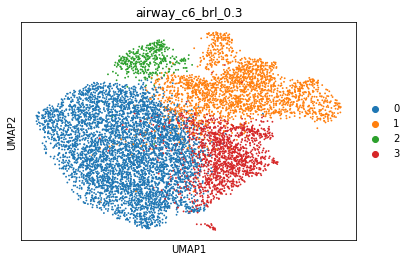

In [5]:
## SUBLINEAGE OBJECT CLUSTERING - AIRWAY (RECLUSTERING OF CLUSTER 6)

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_airway_c6', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering - Resolution at 0.4 was picked for this analysis.
brl.leiden(adata, key_added="airway_c6_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="airway_c6_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="airway_c6_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="airway_c6_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="airway_c6_brl_0.5", resolution=0.5)

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='airway_c6_brl_0.3')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_airway_reclustering_c6_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_airway_reclustering_c6_2024_08_15.csv")

#Migrate to commandline R for sceasy.

### ALVEOLAR

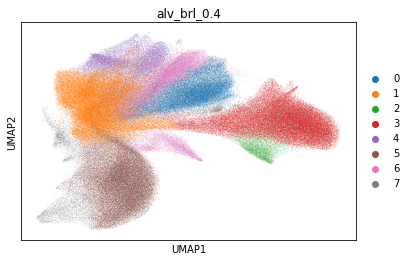

In [3]:
## SUBLINEAGE OBJECT CLUSTERING - ENTIRE ALVEOLAR OBJECT

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_alv', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering 
brl.leiden(adata, key_added="alv_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="alv_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="alv_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="alv_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="alv_brl_0.5", resolution=0.5)

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='alv_brl_0.4')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_alv_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_alv_2024_08_15.csv")

#Migrate to commandline R for sceasy.

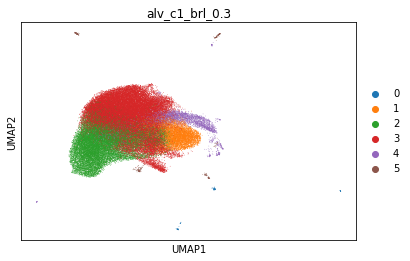

In [2]:
## SUBLINEAGE OBJECT CLUSTERING - ALVEOLAR (RECLUSTERING OF CLUSTER 1)

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_alv_c1', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering 
brl.leiden(adata, key_added="alv_c1_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="alv_c1_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="alv_c1_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="alv_c1_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="alv_c1_brl_0.5", resolution=0.5)

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='alv_c1_brl_0.3')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_alv_reclustering_c1_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_alv_reclustering_c1_2024_08_15.csv")

#Migrate to commandline R for sceasy.

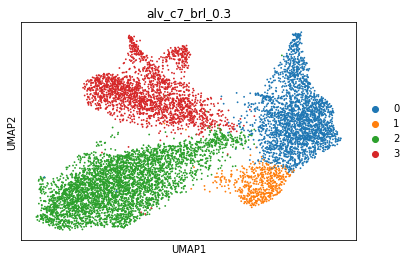

In [3]:
## SUBLINEAGE OBJECT CLUSTERING - ALVEOLAR (RECLUSTERING OF CLUSTER 7)

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_alv_c7', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering
brl.leiden(adata, key_added="alv_c7_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="alv_c7_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="alv_c7_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="alv_c7_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="alv_c7_brl_0.5", resolution=0.5)

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='alv_c7_brl_0.3')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_alv_reclustering_c7_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_alv_reclustering_c7_2024_08_15.csv")

#Migrate to commandline R for sceasy.

In [ ]:
 ## SUBLINEAGE OBJECT CLUSTERING - ENDOTHELIAL (RECLUSTERING OF CLUSTER 2)

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_endo_c2', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering 
brl.leiden(adata, key_added="endo_c2_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="endo_c2_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="endo_c2_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="endo_c2_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="endo_c2_brl_0.5", resolution=0.5)

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='endo_c2_brl_0.3')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_airway_reclustering_c2_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_airway_reclustering_c2_2024_08_15.csv")

#Migrate to commandline R for sceasy.

### ENDOTHELIAL

In [ ]:
## SUBLINEAGE OBJECT CLUSTERING - ENTIRE ENDOTHELIAL OBJECT

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_endo', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering 
brl.leiden(adata, key_added="endo_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="endo_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="endo_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="endo_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="endo_brl_0.5", resolution=0.5)

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='endo_brl_0.3')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_endo_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_endo_2024_08_15.csv")

#Migrate to commandline R for sceasy.

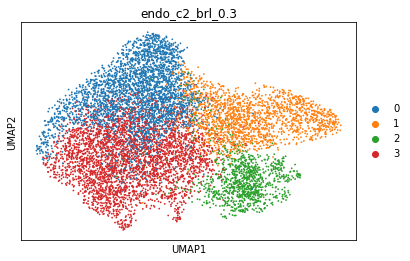

In [10]:
## SUBLINEAGE OBJECT CLUSTERING - ENDOTHELIAL (RECLUSTERING OF CLUSTER 2)

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_endo_c2', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering 
brl.leiden(adata, key_added="endo_c2_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="endo_c2_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="endo_c2_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="endo_c2_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="endo_c2_brl_0.5", resolution=0.5)

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='endo_c2_brl_0.3')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_endo_reclustering_c2_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_endo_reclustering_c2_2024_08_15.csv")

#Migrate to commandline R for sceasy.

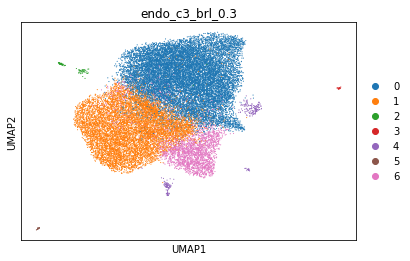

In [9]:
## SUBLINEAGE OBJECT CLUSTERING - ENDOTHELIAL (RECLUSTERING OF CLUSTER 3)

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_endo_c3', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering 
brl.leiden(adata, key_added="endo_c3_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="endo_c3_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="endo_c3_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="endo_c3_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="endo_c3_brl_0.5", resolution=0.5)

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='endo_c3_brl_0.3')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_endo_reclustering_c3_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_endo_reclustering_c3_2024_08_15.csv")

#Migrate to commandline R for sceasy.

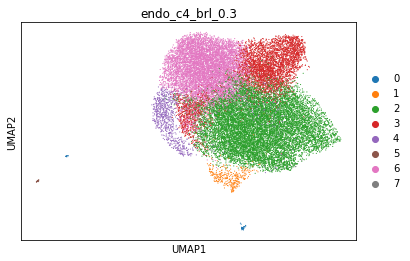

In [11]:
## SUBLINEAGE OBJECT CLUSTERING - ENDOTHELIAL (RECLUSTERING OF CLUSTER 4)

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_endo_c4', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering
brl.leiden(adata, key_added="endo_c4_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="endo_c4_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="endo_c4_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="endo_c4_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="endo_c4_brl_0.5", resolution=0.5)

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='endo_c4_brl_0.3')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_endo_reclustering_c4_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_endo_reclustering_c4_2024_08_15.csv")

#Migrate to commandline R for sceasy.

### MESENCHYMAL

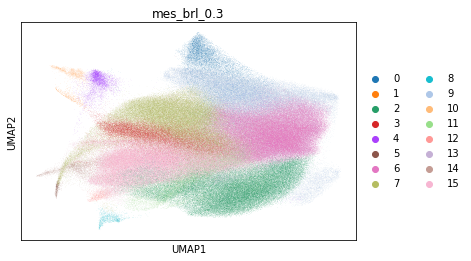

In [5]:
## SUBLINEAGE OBJECT CLUSTERING - ENTIRE MESENCHYMAL OBJECT

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_mes', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering 
brl.leiden(adata, key_added="mes_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="mes_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="mes_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="mes_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="mes_brl_0.5", resolution=0.5)

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='mes_brl_0.3')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_mes_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_mes_2024_08_15.csv")

#Migrate to commandline R for sceasy.

In [ ]:
## SUBLINEAGE OBJECT CLUSTERING - MESENCHYMAL (SUBCLUSTERING)

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_mes', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering 
brl.leiden(adata, key_added="mes_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="mes_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="mes_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="mes_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="mes_brl_0.5", resolution=0.5)

#Change data type for leiden column to string and to category
adata.obs['mes_brl_0.3'] = adata.obs['mes_brl_0.3'].astype('str')
adata.obs['mes_brl_0.3'] = adata.obs['mes_brl_0.3'].astype('category')

#Subclustering 
brl.leiden(adata, key_added="mes_sc_0.3_c0_0.1", resolution=0.1, restrict_to = ("mes_brl_0.3", ["0"]))
brl.leiden(adata, key_added="mes_sc_0.3_c0_0.2", resolution=0.2, restrict_to = ("mes_brl_0.3", ["0"]))
brl.leiden(adata, key_added="mes_sc_0.3_c0_0.3", resolution=0.3, restrict_to = ("mes_brl_0.3", ["0"]))
brl.leiden(adata, key_added="mes_sc_0.3_c0_0.4", resolution=0.4, restrict_to = ("mes_brl_0.3", ["0"]))
brl.leiden(adata, key_added="mes_sc_0.3_c0_0.5", resolution=0.5, restrict_to = ("mes_brl_0.3", ["0"]))

brl.leiden(adata, key_added="mes_sc_0.3_c2_c13_0.1", resolution=0.1, restrict_to = ("mes_brl_0.3", ["2", "13"]))
brl.leiden(adata, key_added="mes_sc_0.3_c2_c13_0.2", resolution=0.2, restrict_to = ("mes_brl_0.3", ["2", "13"]))
brl.leiden(adata, key_added="mes_sc_0.3_c2_c13_0.3", resolution=0.3, restrict_to = ("mes_brl_0.3", ["2", "13"]))
brl.leiden(adata, key_added="mes_sc_0.3_c2_c13_0.4", resolution=0.4, restrict_to = ("mes_brl_0.3", ["2", "13"]))
brl.leiden(adata, key_added="mes_sc_0.3_c2_c13_0.5", resolution=0.5, restrict_to = ("mes_brl_0.3", ["2", "13"]))

brl.leiden(adata, key_added="mes_sc_0.3_c7_0.1", resolution=0.1, restrict_to = ("mes_brl_0.3", ["7"]))
brl.leiden(adata, key_added="mes_sc_0.3_c7_0.2", resolution=0.2, restrict_to = ("mes_brl_0.3", ["7"]))
brl.leiden(adata, key_added="mes_sc_0.3_c7_0.3", resolution=0.3, restrict_to = ("mes_brl_0.3", ["7"]))
brl.leiden(adata, key_added="mes_sc_0.3_c7_0.4", resolution=0.4, restrict_to = ("mes_brl_0.3", ["7"]))
brl.leiden(adata, key_added="mes_sc_0.3_c7_0.5", resolution=0.5, restrict_to = ("mes_brl_0.3", ["7"]))

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='mes_sc_0.3_c7_0.1')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_mes_subclustering_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_mes_subclustering_2024_08_15.csv")

#Migrate to commandline R for sceasy.

In [ ]:
## SUBLINEAGE OBJECT CLUSTERING - MESENCHYMAL (RECLUSTERING OF CLUSTER 11)

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_mes_c11', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering 
brl.leiden(adata, key_added="mes_c11_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="mes_c11_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="mes_c11_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="mes_c11_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="mes_c11_brl_0.5", resolution=0.5)

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='mes_c11_brl_0.3')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_mes_reclustering_c11_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_mes_reclustering_c11_2024_08_15.csv")

#Migrate to commandline R for sceasy.

In [ ]:
## SUBLINEAGE OBJECT CLUSTERING - MESENCHYMAL (RECLUSTERING OF CLUSTER 12)

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_mes_c12', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering 
brl.leiden(adata, key_added="mes_c12_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="mes_c12_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="mes_c12_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="mes_c12_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="mes_c12_brl_0.5", resolution=0.5)

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='mes_c12_brl_0.3')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_mes_reclustering_c12_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_mes_reclustering_c12_2024_08_15.csv")

#Migrate to commandline R for sceasy.

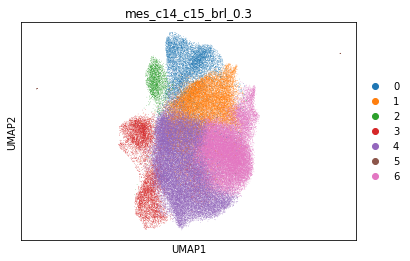

In [2]:
## SUBLINEAGE OBJECT CLUSTERING - MESENCHYMAL (RECLUSTERING OF CLUSTERS 14 AND 15)

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_mes_c14_15', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering 
brl.leiden(adata, key_added="mes_c14_c15_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="mes_c14_c15_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="mes_c14_c15_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="mes_c14_c15_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="mes_c14_c15_brl_0.5", resolution=0.5)

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='mes_c14_c15_brl_0.3')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_mes_reclustering_c14_c15_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_mes_reclustering_c14_c15_2024_08_15.csv")

#Migrate to commandline R for sceasy.

### LYMPHOID

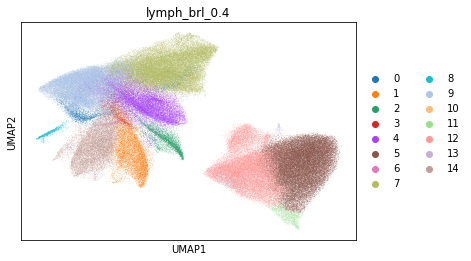

In [6]:
## SUBLINEAGE OBJECT CLUSTERING - ENTIRE LYMPHOID OBJECT

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_lymph', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering - Resolution at 0.4 was picked for this analysis.
brl.leiden(adata, key_added="lymph_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="lymph_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="lymph_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="lymph_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="lymph_brl_0.5", resolution=0.5)

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='lymph_brl_0.4')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_lymph_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_lymph_2024_08_15.csv")

#Migrate to commandline R for sceasy.

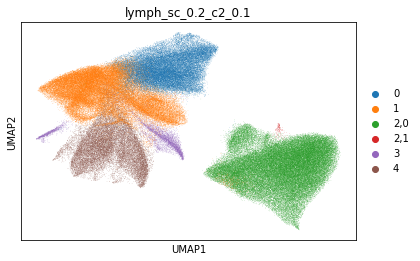

In [2]:
## SUBLINEAGE OBJECT CLUSTERING - LYMPHOID (SUBCLUSTERING)

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_lymph', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering - Resolution at 0.4 was picked for this analysis.
brl.leiden(adata, key_added="lymph_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="lymph_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="lymph_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="lymph_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="lymph_brl_0.5", resolution=0.5)

#Change data type for leiden column to string and to category
adata.obs['lymph_brl_0.2'] = adata.obs['lymph_brl_0.2'].astype('str')
adata.obs['lymph_brl_0.2'] = adata.obs['lymph_brl_0.2'].astype('category')

#Subclustering 
brl.leiden(adata, key_added="lymph_sc_0.2_c0_0.1", resolution=0.1, restrict_to = ("lymph_brl_0.2", ["0"]))
brl.leiden(adata, key_added="lymph_sc_0.2_c0_0.2", resolution=0.2, restrict_to = ("lymph_brl_0.2", ["0"]))
brl.leiden(adata, key_added="lymph_sc_0.2_c0_0.3", resolution=0.3, restrict_to = ("lymph_brl_0.2", ["0"]))
brl.leiden(adata, key_added="lymph_sc_0.2_c0_0.4", resolution=0.4, restrict_to = ("lymph_brl_0.2", ["0"]))
brl.leiden(adata, key_added="lymph_sc_0.2_c0_0.5", resolution=0.5, restrict_to = ("lymph_brl_0.2", ["0"]))

brl.leiden(adata, key_added="lymph_sc_0.2_c1_0.1", resolution=0.1, restrict_to = ("lymph_brl_0.2", ["1"]))
brl.leiden(adata, key_added="lymph_sc_0.2_c1_0.2", resolution=0.2, restrict_to = ("lymph_brl_0.2", ["1"]))
brl.leiden(adata, key_added="lymph_sc_0.2_c1_0.3", resolution=0.3, restrict_to = ("lymph_brl_0.2", ["1"]))
brl.leiden(adata, key_added="lymph_sc_0.2_c1_0.4", resolution=0.4, restrict_to = ("lymph_brl_0.2", ["1"]))
brl.leiden(adata, key_added="lymph_sc_0.2_c1_0.5", resolution=0.5, restrict_to = ("lymph_brl_0.2", ["1"]))

brl.leiden(adata, key_added="lymph_sc_0.2_c2_0.1", resolution=0.1, restrict_to = ("lymph_brl_0.2", ["2"]))
brl.leiden(adata, key_added="lymph_sc_0.2_c2_0.2", resolution=0.2, restrict_to = ("lymph_brl_0.2", ["2"]))
brl.leiden(adata, key_added="lymph_sc_0.2_c2_0.3", resolution=0.3, restrict_to = ("lymph_brl_0.2", ["2"]))
brl.leiden(adata, key_added="lymph_sc_0.2_c2_0.4", resolution=0.4, restrict_to = ("lymph_brl_0.2", ["2"]))
brl.leiden(adata, key_added="lymph_sc_0.2_c2_0.5", resolution=0.5, restrict_to = ("lymph_brl_0.2", ["2"]))

brl.leiden(adata, key_added="lymph_sc_0.2_c3_0.1", resolution=0.1, restrict_to = ("lymph_brl_0.2", ["3"]))
brl.leiden(adata, key_added="lymph_sc_0.2_c3_0.2", resolution=0.2, restrict_to = ("lymph_brl_0.2", ["3"]))
brl.leiden(adata, key_added="lymph_sc_0.2_c3_0.3", resolution=0.3, restrict_to = ("lymph_brl_0.2", ["3"]))
brl.leiden(adata, key_added="lymph_sc_0.2_c3_0.4", resolution=0.4, restrict_to = ("lymph_brl_0.2", ["3"]))
brl.leiden(adata, key_added="lymph_sc_0.2_c3_0.5", resolution=0.5, restrict_to = ("lymph_brl_0.2", ["3"]))

brl.leiden(adata, key_added="lymph_sc_0.2_c4_0.1", resolution=0.1, restrict_to = ("lymph_brl_0.2", ["4"]))
brl.leiden(adata, key_added="lymph_sc_0.2_c4_0.2", resolution=0.2, restrict_to = ("lymph_brl_0.2", ["4"]))
brl.leiden(adata, key_added="lymph_sc_0.2_c4_0.3", resolution=0.3, restrict_to = ("lymph_brl_0.2", ["4"]))
brl.leiden(adata, key_added="lymph_sc_0.2_c4_0.4", resolution=0.4, restrict_to = ("lymph_brl_0.2", ["4"]))
brl.leiden(adata, key_added="lymph_sc_0.2_c4_0.5", resolution=0.5, restrict_to = ("lymph_brl_0.2", ["4"]))

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='lymph_sc_0.2_c2_0.1')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_lymph_subclustering_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_lymph_subclustering_2024_08_15.csv")

#Migrate to commandline R for sceasy.

### MYELOID

In [ ]:
## SUBLINEAGE OBJECT CLUSTERING - ENTIRE MYELOID OBJECT

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_mye', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering - Resolution at 0.4 was picked for this analysis.
brl.leiden(adata, key_added="mye_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="mye_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="mye_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="mye_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="mye_brl_0.5", resolution=0.5)

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='mye_brl_0.4')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_mye_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_mye_2024_08_15.csv")

#Migrate to commandline R for sceasy.


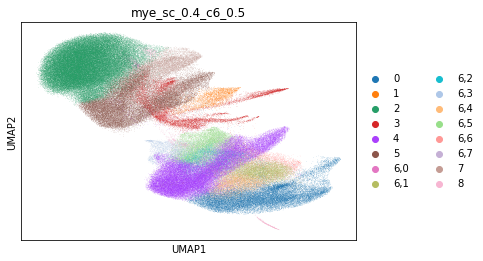

In [2]:
## SUBLINEAGE OBJECT CLUSTERING - MYELOID (SUBCLUSTERING)

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_mye', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering - Resolution at 0.4 was picked for this analysis.
brl.leiden(adata, key_added="mye_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="mye_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="mye_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="mye_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="mye_brl_0.5", resolution=0.5)

#Change data type for leiden column to string and to category
adata.obs['mye_brl_0.4'] = adata.obs['mye_brl_0.4'].astype('str')
adata.obs['mye_brl_0.4'] = adata.obs['mye_brl_0.4'].astype('category')

#Subclustering
brl.leiden(adata, key_added="mye_sc_0.4_c4_0.1", resolution=0.1, restrict_to = ("mye_brl_0.4", ["4"]))
brl.leiden(adata, key_added="mye_sc_0.4_c4_0.2", resolution=0.2, restrict_to = ("mye_brl_0.4", ["4"]))
brl.leiden(adata, key_added="mye_sc_0.4_c4_0.3", resolution=0.3, restrict_to = ("mye_brl_0.4", ["4"]))
brl.leiden(adata, key_added="mye_sc_0.4_c4_0.4", resolution=0.4, restrict_to = ("mye_brl_0.4", ["4"]))
brl.leiden(adata, key_added="mye_sc_0.4_c4_0.5", resolution=0.5, restrict_to = ("mye_brl_0.4", ["4"]))

brl.leiden(adata, key_added="mye_sc_0.4_c5_0.1", resolution=0.1, restrict_to = ("mye_brl_0.4", ["5"]))
brl.leiden(adata, key_added="mye_sc_0.4_c5_0.2", resolution=0.2, restrict_to = ("mye_brl_0.4", ["5"]))
brl.leiden(adata, key_added="mye_sc_0.4_c5_0.3", resolution=0.3, restrict_to = ("mye_brl_0.4", ["5"]))
brl.leiden(adata, key_added="mye_sc_0.4_c5_0.4", resolution=0.4, restrict_to = ("mye_brl_0.4", ["5"]))
brl.leiden(adata, key_added="mye_sc_0.4_c5_0.5", resolution=0.5, restrict_to = ("mye_brl_0.4", ["5"]))

brl.leiden(adata, key_added="mye_sc_0.4_c6_0.1", resolution=0.1, restrict_to = ("mye_brl_0.4", ["6"]))
brl.leiden(adata, key_added="mye_sc_0.4_c6_0.2", resolution=0.2, restrict_to = ("mye_brl_0.4", ["6"]))
brl.leiden(adata, key_added="mye_sc_0.4_c6_0.3", resolution=0.3, restrict_to = ("mye_brl_0.4", ["6"]))
brl.leiden(adata, key_added="mye_sc_0.4_c6_0.4", resolution=0.4, restrict_to = ("mye_brl_0.4", ["6"]))
brl.leiden(adata, key_added="mye_sc_0.4_c6_0.5", resolution=0.5, restrict_to = ("mye_brl_0.4", ["6"]))

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='mye_sc_0.4_c6_0.5')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_mye_subclustering_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_mye_subclustering_2024_08_15.csv")

#Migrate to commandline R for sceasy.

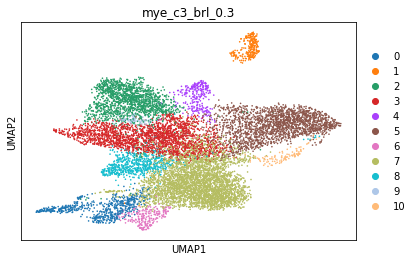

In [5]:
## SUBLINEAGE OBJECT CLUSTERING - MYELOID (RECLUSTERING OF CLUSTER 3)

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_mye_c3', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering 
brl.leiden(adata, key_added="mye_c3_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="mye_c3_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="mye_c3_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="mye_c3_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="mye_c3_brl_0.5", resolution=0.5)

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='mye_c3_brl_0.3')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_mye_reclustering_c3_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_mye_reclustering_c3_2024_08_15.csv")

#Migrate to commandline R for sceasy.

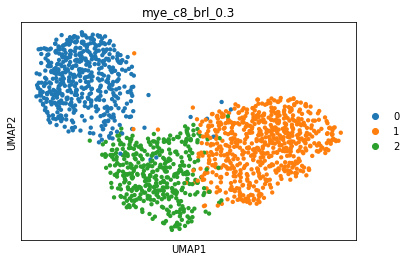

In [6]:
## SUBLINEAGE OBJECT CLUSTERING - MYELOID (RECLUSTERING OF CLUSTER 8)

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_mye_c8', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering 
brl.leiden(adata, key_added="mye_c8_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="mye_c8_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="mye_c8_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="mye_c8_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="mye_c8_brl_0.5", resolution=0.5)

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='mye_c8_brl_0.3')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_mye_reclustering_c8_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_mye_reclustering_c8_2024_08_15.csv")

#Migrate to commandline R for sceasy.

### SECONDARY OBJECTS

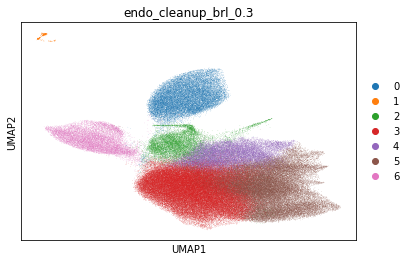

In [2]:
## GRANULAR LABELING - ENDOTHELIAL CLEAN UP

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_endo_cleanup', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering 
brl.leiden(adata, key_added="endo_cleanup_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="endo_cleanup_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="endo_cleanup_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="endo_cleanup_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="endo_cleanup_brl_0.5", resolution=0.5)

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='endo_cleanup_brl_0.3')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_endo_CTs_cleanup_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_endo_CTs_cleanup_2024_08_15.csv")

#Migrate to commandline R for sceasy.

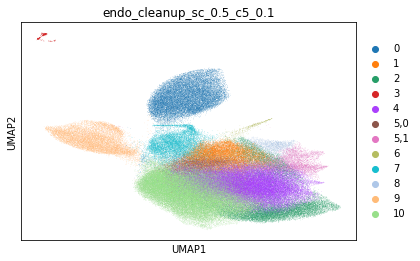

In [4]:
## GRANULAR LABELING - ENDOTHELIAL CLEAN UP (SUBCLUSTERING)

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_endo_cleanup', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering 
brl.leiden(adata, key_added="endo_cleanup_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="endo_cleanup_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="endo_cleanup_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="endo_cleanup_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="endo_cleanup_brl_0.5", resolution=0.5)

#Change data type for leiden column to string and to category
adata.obs['endo_cleanup_brl_0.5'] = adata.obs['endo_cleanup_brl_0.5'].astype('str')
adata.obs['endo_cleanup_brl_0.5'] = adata.obs['endo_cleanup_brl_0.5'].astype('category')

#Subclustering
brl.leiden(adata, key_added="endo_cleanup_sc_0.5_c1_0.1", resolution=0.1, restrict_to = ("endo_cleanup_brl_0.5", ["1"]))
brl.leiden(adata, key_added="endo_cleanup_sc_0.5_c1_0.2", resolution=0.2, restrict_to = ("endo_cleanup_brl_0.5", ["1"]))
brl.leiden(adata, key_added="endo_cleanup_sc_0.5_c1_0.3", resolution=0.3, restrict_to = ("endo_cleanup_brl_0.5", ["1"]))
brl.leiden(adata, key_added="endo_cleanup_sc_0.5_c1_0.4", resolution=0.4, restrict_to = ("endo_cleanup_brl_0.5", ["1"]))
brl.leiden(adata, key_added="endo_cleanup_sc_0.5_c1_0.5", resolution=0.5, restrict_to = ("endo_cleanup_brl_0.5", ["1"]))

brl.leiden(adata, key_added="endo_cleanup_sc_0.5_c5_0.1", resolution=0.1, restrict_to = ("endo_cleanup_brl_0.5", ["5"]))
brl.leiden(adata, key_added="endo_cleanup_sc_0.5_c5_0.2", resolution=0.2, restrict_to = ("endo_cleanup_brl_0.5", ["5"]))
brl.leiden(adata, key_added="endo_cleanup_sc_0.5_c5_0.3", resolution=0.3, restrict_to = ("endo_cleanup_brl_0.5", ["5"]))
brl.leiden(adata, key_added="endo_cleanup_sc_0.5_c5_0.4", resolution=0.4, restrict_to = ("endo_cleanup_brl_0.5", ["5"]))
brl.leiden(adata, key_added="endo_cleanup_sc_0.5_c5_0.5", resolution=0.5, restrict_to = ("endo_cleanup_brl_0.5", ["5"]))

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='endo_cleanup_sc_0.5_c5_0.1')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_endo_CTs_cleanup_sc_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_endo_CTs_cleanup_sc_2024_08_15.csv")

#Migrate to commandline R for sceasy.

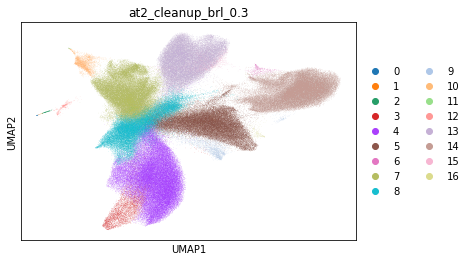

In [5]:
## GRANULAR LABELING - AT2 CLEAN UP

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_at2_cleanup', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering 
brl.leiden(adata, key_added="at2_cleanup_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="at2_cleanup_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="at2_cleanup_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="at2_cleanup_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="at2_cleanup_brl_0.5", resolution=0.5)

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='at2_cleanup_brl_0.3')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_at2_CTs_cleanup_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_at2_CTs_cleanup_2024_08_15.csv")

#Migrate to commandline R for sceasy.

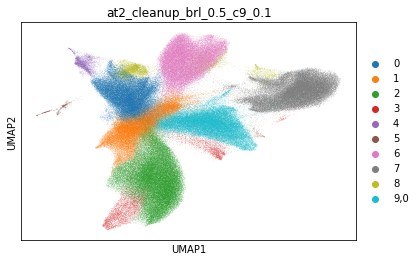

In [6]:
## GRANULAR LABELING - AT2 CLEAN UP (SUBCLUSTERING)

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_at2_cleanup', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering 
brl.leiden(adata, key_added="at2_cleanup_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="at2_cleanup_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="at2_cleanup_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="at2_cleanup_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="at2_cleanup_brl_0.5", resolution=0.5)

#Change data type for leiden column to string and to category
adata.obs['at2_cleanup_brl_0.5'] = adata.obs['at2_cleanup_brl_0.5'].astype('str')
adata.obs['at2_cleanup_brl_0.5'] = adata.obs['at2_cleanup_brl_0.5'].astype('category')

#Subclustering
brl.leiden(adata, key_added="at2_cleanup_brl_0.5_c1_0.1", resolution=0.1, restrict_to = ("at2_cleanup_brl_0.5", ["1"]))
brl.leiden(adata, key_added="at2_cleanup_brl_0.5_c1_0.2", resolution=0.2, restrict_to = ("at2_cleanup_brl_0.5", ["1"]))
brl.leiden(adata, key_added="at2_cleanup_brl_0.5_c1_0.3", resolution=0.3, restrict_to = ("at2_cleanup_brl_0.5", ["1"]))
brl.leiden(adata, key_added="at2_cleanup_brl_0.5_c1_0.4", resolution=0.4, restrict_to = ("at2_cleanup_brl_0.5", ["1"]))
brl.leiden(adata, key_added="at2_cleanup_brl_0.5_c1_0.5", resolution=0.5, restrict_to = ("at2_cleanup_brl_0.5", ["1"]))

brl.leiden(adata, key_added="at2_cleanup_brl_0.5_c9_0.1", resolution=0.1, restrict_to = ("at2_cleanup_brl_0.5", ["9"]))
brl.leiden(adata, key_added="at2_cleanup_brl_0.5_c9_0.2", resolution=0.2, restrict_to = ("at2_cleanup_brl_0.5", ["9"]))
brl.leiden(adata, key_added="at2_cleanup_brl_0.5_c9_0.3", resolution=0.3, restrict_to = ("at2_cleanup_brl_0.5", ["9"]))
brl.leiden(adata, key_added="at2_cleanup_brl_0.5_c9_0.4", resolution=0.4, restrict_to = ("at2_cleanup_brl_0.5", ["9"]))
brl.leiden(adata, key_added="at2_cleanup_brl_0.5_c9_0.5", resolution=0.5, restrict_to = ("at2_cleanup_brl_0.5", ["9"]))

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='at2_cleanup_brl_0.5_c9_0.1')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_at2_CTs_cleanup_sc_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_at2_CTs_cleanup_sc_2024_08_15.csv")

#Migrate to commandline R for sceasy.

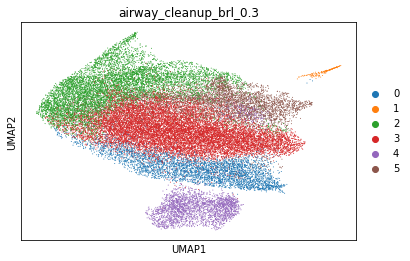

In [3]:
## GRANULAR LABELING - AIRWAY CLEAN UP

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_airway_cleanup', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering 
brl.leiden(adata, key_added="airway_cleanup_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="airway_cleanup_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="airway_cleanup_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="airway_cleanup_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="airway_cleanup_brl_0.5", resolution=0.5)

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='airway_cleanup_brl_0.3')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_airway_CTs_cleanup_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_airway_CTs_cleanup_2024_08_15.csv")

#Migrate to commandline R for sceasy.

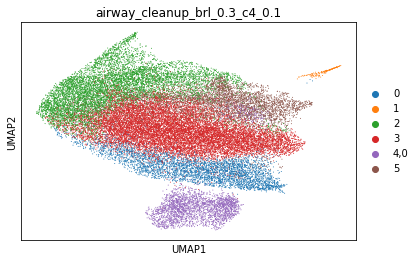

In [4]:
## GRANULAR LABELING - AIRWAY CLEAN UP (SUBCLUSTERING)

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_airway_cleanup', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering 
brl.leiden(adata, key_added="airway_cleanup_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="airway_cleanup_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="airway_cleanup_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="airway_cleanup_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="airway_cleanup_brl_0.5", resolution=0.5)

#Change data type for leiden column to string and to category
adata.obs['airway_cleanup_brl_0.3'] = adata.obs['airway_cleanup_brl_0.3'].astype('str')
adata.obs['airway_cleanup_brl_0.3'] = adata.obs['airway_cleanup_brl_0.3'].astype('category')

#Subclustering
brl.leiden(adata, key_added="airway_cleanup_brl_0.3_c0_0.1", resolution=0.1, restrict_to = ("airway_cleanup_brl_0.3", ["0"]))
brl.leiden(adata, key_added="airway_cleanup_brl_0.3_c0_0.2", resolution=0.2, restrict_to = ("airway_cleanup_brl_0.3", ["0"]))
brl.leiden(adata, key_added="airway_cleanup_brl_0.3_c0_0.3", resolution=0.3, restrict_to = ("airway_cleanup_brl_0.3", ["0"]))
brl.leiden(adata, key_added="airway_cleanup_brl_0.3_c0_0.4", resolution=0.4, restrict_to = ("airway_cleanup_brl_0.3", ["0"]))
brl.leiden(adata, key_added="airway_cleanup_brl_0.3_c0_0.5", resolution=0.5, restrict_to = ("airway_cleanup_brl_0.3", ["0"]))

brl.leiden(adata, key_added="airway_cleanup_brl_0.3_c2_0.1", resolution=0.1, restrict_to = ("airway_cleanup_brl_0.3", ["2"]))
brl.leiden(adata, key_added="airway_cleanup_brl_0.3_c2_0.2", resolution=0.2, restrict_to = ("airway_cleanup_brl_0.3", ["2"]))
brl.leiden(adata, key_added="airway_cleanup_brl_0.3_c2_0.3", resolution=0.3, restrict_to = ("airway_cleanup_brl_0.3", ["2"]))
brl.leiden(adata, key_added="airway_cleanup_brl_0.3_c2_0.4", resolution=0.4, restrict_to = ("airway_cleanup_brl_0.3", ["2"]))
brl.leiden(adata, key_added="airway_cleanup_brl_0.3_c2_0.5", resolution=0.5, restrict_to = ("airway_cleanup_brl_0.3", ["2"]))

brl.leiden(adata, key_added="airway_cleanup_brl_0.3_c4_0.1", resolution=0.1, restrict_to = ("airway_cleanup_brl_0.3", ["4"]))
brl.leiden(adata, key_added="airway_cleanup_brl_0.3_c4_0.2", resolution=0.2, restrict_to = ("airway_cleanup_brl_0.3", ["4"]))
brl.leiden(adata, key_added="airway_cleanup_brl_0.3_c4_0.3", resolution=0.3, restrict_to = ("airway_cleanup_brl_0.3", ["4"]))
brl.leiden(adata, key_added="airway_cleanup_brl_0.3_c4_0.4", resolution=0.4, restrict_to = ("airway_cleanup_brl_0.3", ["4"]))
brl.leiden(adata, key_added="airway_cleanup_brl_0.3_c4_0.5", resolution=0.5, restrict_to = ("airway_cleanup_brl_0.3", ["4"]))

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='airway_cleanup_brl_0.3_c4_0.1')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_airway_CTs_cleanup_sc_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_airway_CTs_cleanup_sc_2024_08_15.csv")

#Migrate to commandline R for sceasy.

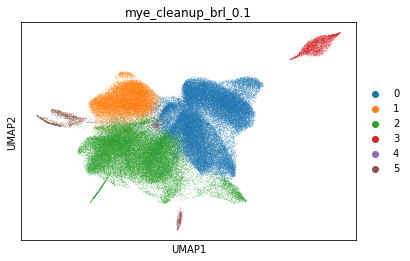

In [2]:
## GRANULAR LABELING - MYELOID CLEAN UP

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_mye_cleanup', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering 
brl.leiden(adata, key_added="mye_cleanup_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="mye_cleanup_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="mye_cleanup_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="mye_cleanup_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="mye_cleanup_brl_0.5", resolution=0.5)

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='mye_cleanup_brl_0.1')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_mye_CTs_cleanup_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_mye_CTs_cleanup_2024_08_15.csv")

#Migrate to commandline R for sceasy.

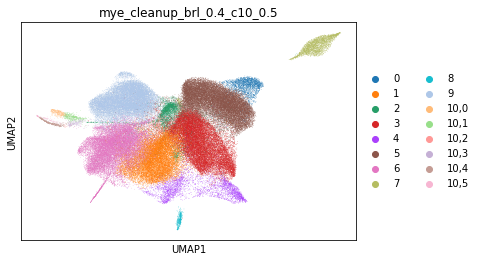

In [3]:
## GRANULAR LABELING - MYELOID CLEAN UP (SUBCLUSTERING)

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_mye_cleanup', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering 
brl.leiden(adata, key_added="mye_cleanup_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="mye_cleanup_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="mye_cleanup_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="mye_cleanup_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="mye_cleanup_brl_0.5", resolution=0.5)

#Change data type for leiden column to string and to category
adata.obs['mye_cleanup_brl_0.4'] = adata.obs['mye_cleanup_brl_0.4'].astype('str')
adata.obs['mye_cleanup_brl_0.4'] = adata.obs['mye_cleanup_brl_0.4'].astype('category')

#Subclustering
brl.leiden(adata, key_added="mye_cleanup_brl_0.4_c4_0.1", resolution=0.1, restrict_to = ("mye_cleanup_brl_0.4", ["4"]))
brl.leiden(adata, key_added="mye_cleanup_brl_0.4_c4_0.2", resolution=0.2, restrict_to = ("mye_cleanup_brl_0.4", ["4"]))
brl.leiden(adata, key_added="mye_cleanup_brl_0.4_c4_0.3", resolution=0.3, restrict_to = ("mye_cleanup_brl_0.4", ["4"]))
brl.leiden(adata, key_added="mye_cleanup_brl_0.4_c4_0.4", resolution=0.4, restrict_to = ("mye_cleanup_brl_0.4", ["4"]))
brl.leiden(adata, key_added="mye_cleanup_brl_0.4_c4_0.5", resolution=0.5, restrict_to = ("mye_cleanup_brl_0.4", ["4"]))

brl.leiden(adata, key_added="mye_cleanup_brl_0.4_c6_0.1", resolution=0.1, restrict_to = ("mye_cleanup_brl_0.4", ["6"]))
brl.leiden(adata, key_added="mye_cleanup_brl_0.4_c6_0.2", resolution=0.2, restrict_to = ("mye_cleanup_brl_0.4", ["6"]))
brl.leiden(adata, key_added="mye_cleanup_brl_0.4_c6_0.3", resolution=0.3, restrict_to = ("mye_cleanup_brl_0.4", ["6"]))
brl.leiden(adata, key_added="mye_cleanup_brl_0.4_c6_0.4", resolution=0.4, restrict_to = ("mye_cleanup_brl_0.4", ["6"]))
brl.leiden(adata, key_added="mye_cleanup_brl_0.4_c6_0.5", resolution=0.5, restrict_to = ("mye_cleanup_brl_0.4", ["6"]))

brl.leiden(adata, key_added="mye_cleanup_brl_0.4_c10_0.1", resolution=0.1, restrict_to = ("mye_cleanup_brl_0.4", ["10"]))
brl.leiden(adata, key_added="mye_cleanup_brl_0.4_c10_0.2", resolution=0.2, restrict_to = ("mye_cleanup_brl_0.4", ["10"]))
brl.leiden(adata, key_added="mye_cleanup_brl_0.4_c10_0.3", resolution=0.3, restrict_to = ("mye_cleanup_brl_0.4", ["10"]))
brl.leiden(adata, key_added="mye_cleanup_brl_0.4_c10_0.4", resolution=0.4, restrict_to = ("mye_cleanup_brl_0.4", ["10"]))
brl.leiden(adata, key_added="mye_cleanup_brl_0.4_c10_0.5", resolution=0.5, restrict_to = ("mye_cleanup_brl_0.4", ["10"]))

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='mye_cleanup_brl_0.4_c10_0.5')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_mye_CTs_cleanup_sc_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_mye_CTs_cleanup_sc_2024_08_15.csv")

#Migrate to commandline R for sceasy.

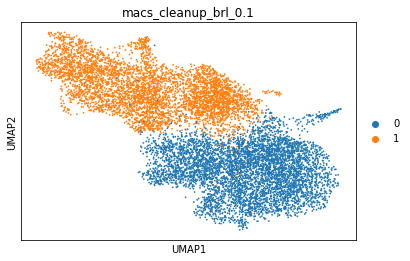

In [5]:
## GRANULAR LABELING - MACROPHAGE CLEAN UP

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_mac_cleanup', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering 
brl.leiden(adata, key_added="macs_cleanup_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="macs_cleanup_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="macs_cleanup_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="macs_cleanup_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="macs_cleanup_brl_0.5", resolution=0.5)

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='macs_cleanup_brl_0.1')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_macs_CTs_cleanup_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_macs_CTs_cleanup_2024_08_15.csv")

#Migrate to commandline R for sceasy.

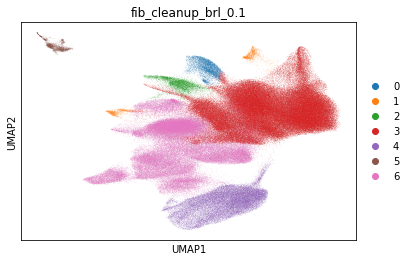

In [6]:
## GRANULAR LABELING - FIBROBLASTS CLEAN UP

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_fib_cleanup', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering 
brl.leiden(adata, key_added="fib_cleanup_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="fib_cleanup_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="fib_cleanup_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="fib_cleanup_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="fib_cleanup_brl_0.5", resolution=0.5)

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='fib_cleanup_brl_0.1')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_fib_CTs_cleanup_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_fib_CTs_cleanup_2024_08_15.csv")

#Migrate to commandline R for sceasy.

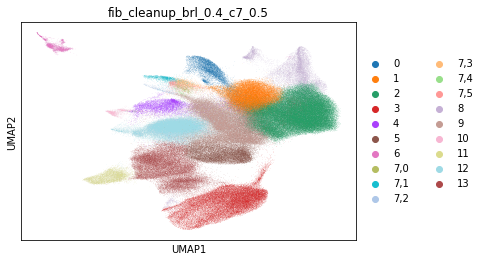

In [7]:
## GRANULAR LABELING - FIBROBLASTS CLEAN UP (SUBCLUSTERING)

#Read in anndata as a pickle file from seurat_to_anndata.ipynb script.
with open('merged_spatial_filtered_fib_cleanup', 'rb') as f:
    adata = pickle.load(f)

#Storing raw counts separately.
adata.raw = adata

#Normalize data.
sc.pp.log1p(adata)

#Scale data.
sc.pp.scale(adata)

#Run PCA.
sc.tl.pca(adata, n_comps=20)

#Find neighbours. 
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

#Leiden clustering 
brl.leiden(adata, key_added="fib_cleanup_brl_0.1", resolution=0.1)
brl.leiden(adata, key_added="fib_cleanup_brl_0.2", resolution=0.2)
brl.leiden(adata, key_added="fib_cleanup_brl_0.3", resolution=0.3)
brl.leiden(adata, key_added="fib_cleanup_brl_0.4", resolution=0.4)
brl.leiden(adata, key_added="fib_cleanup_brl_0.5", resolution=0.5)

#Change data type for leiden column to string and to category
adata.obs['fib_cleanup_brl_0.4'] = adata.obs['fib_cleanup_brl_0.4'].astype('str')
adata.obs['fib_cleanup_brl_0.4'] = adata.obs['fib_cleanup_brl_0.4'].astype('category')

#Subclustering
brl.leiden(adata, key_added="fib_cleanup_brl_0.4_c1_0.1", resolution=0.1, restrict_to = ("fib_cleanup_brl_0.4", ["1"]))
brl.leiden(adata, key_added="fib_cleanup_brl_0.4_c1_0.2", resolution=0.2, restrict_to = ("fib_cleanup_brl_0.4", ["1"]))
brl.leiden(adata, key_added="fib_cleanup_brl_0.4_c1_0.3", resolution=0.3, restrict_to = ("fib_cleanup_brl_0.4", ["1"]))
brl.leiden(adata, key_added="fib_cleanup_brl_0.4_c1_0.4", resolution=0.4, restrict_to = ("fib_cleanup_brl_0.4", ["1"]))
brl.leiden(adata, key_added="fib_cleanup_brl_0.4_c1_0.5", resolution=0.5, restrict_to = ("fib_cleanup_brl_0.4", ["1"]))

brl.leiden(adata, key_added="fib_cleanup_brl_0.4_c7_0.1", resolution=0.1, restrict_to = ("fib_cleanup_brl_0.4", ["7"]))
brl.leiden(adata, key_added="fib_cleanup_brl_0.4_c7_0.2", resolution=0.2, restrict_to = ("fib_cleanup_brl_0.4", ["7"]))
brl.leiden(adata, key_added="fib_cleanup_brl_0.4_c7_0.3", resolution=0.3, restrict_to = ("fib_cleanup_brl_0.4", ["7"]))
brl.leiden(adata, key_added="fib_cleanup_brl_0.4_c7_0.4", resolution=0.4, restrict_to = ("fib_cleanup_brl_0.4", ["7"]))
brl.leiden(adata, key_added="fib_cleanup_brl_0.4_c7_0.5", resolution=0.5, restrict_to = ("fib_cleanup_brl_0.4", ["7"]))

#Run UMAP. 
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='fib_cleanup_brl_0.4_c7_0.5')

#Copying raw counts back to object.
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

#Cast all int32 variables in metadata to float64 so that the object can be converted back to Seurat.
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["x_centroid"] = adata.obs["x_centroid"].astype('float64')
adata.obs["y_centroid"] = adata.obs["y_centroid"].astype('float64')
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["cell_area"] = adata.obs["cell_area"].astype('float64')
adata.obs["nucleus_area"] = adata.obs["nucleus_area"].astype('float64')
adata.obs["percent_negcodes"] = adata.obs["percent_negcodes"].astype('float64')
adata.obs["percent_negprobes"] = adata.obs["percent_negprobes"].astype('float64')
adata.obs["adj_x_centroid"] = adata.obs["adj_x_centroid"].astype('float64')
adata.obs["adj_y_centroid"] = adata.obs["adj_y_centroid"].astype('float64')

#Write anndata to h5 file to import into R for conversion to Seurat object.
adata.write_h5ad(filename="run2_fib_CTs_cleanup_sc_2024_08_15.h5ad")

#Save metadata as a separate object to integrate later on.
clustered_metadata = adata.obs
metadata = pd.DataFrame.to_csv(clustered_metadata, "/scratch/smallapragada/rapids_pipeline/run2_fib_CTs_cleanup_sc_2024_08_15.csv")

#Migrate to commandline R for sceasy.